# Extract Mechanisms from Space

## Setup Environment

In [1]:
import os
import numpy as np
import pandas as pd

import scanpy as sc
import squidpy as sq
import liana as li
import matplotlib.pyplot as plt

In [2]:
import decoupler as dc

In [3]:
import plotnine as p9
from decoupler import p_adjust_fdr

In [4]:
import seaborn as sns

In [5]:
import sys
sys.path.append(os.path.join('..', 'spot_calling'))
from utils import load_prep_slide

In [6]:
data_dir = os.path.join('..', '..', 'data', 'heart_visium')
dataset_names = [f for f in os.listdir(data_dir) if f.endswith('.h5ad')]

In [7]:
metadata = pd.read_csv(os.path.join("..", "spot_calling", "visium_meta.csv")).set_index('slide_name')
group_dict = {'group_1': 'Myogenic', 'group_2':'Ischemic', 'group_3': 'Fibrotic'}
rename_dict = {'Myogenic': 'Myogenic \n (n=14)', 'Ischemic':'Ischemic \n (n=9)', 'Fibrotic': 'Fibrotic \n (n=5)'}
condition_key = 'patient_group'

In [8]:
metadata['patient_group'] = metadata['patient_group'].map(group_dict)

## Process Datasets

In [9]:
lrdatas = {}

for dataset_name in dataset_names:
   sample_id = metadata.loc[dataset_name.replace('.h5ad', ''), 'hca_sample_id']
   
   print(f"dataset_name: {dataset_name}; {sample_id}")
   adata = load_prep_slide(data_dir, dataset_name, add_sample_name=True)

   li.ut.spatial_neighbors(adata, bandwidth=150, set_diag=True, cutoff=0.1)

   adata.write_h5ad(os.path.join('results', 'processed', sample_id + '.h5ad'))

   li.mt.lr_bivar(adata,
                  function_name='cosine',
                  expr_prop=0.1,
                  n_perms=None, # NOTE, some bug here
                  use_raw=False,
                  add_categories=False,
                  # mask_negatives=True,
                  )
   lrdata = adata.obsm['local_scores']
   
   # save to folder
   lrdata.write_h5ad(os.path.join('results', 'lr', sample_id + '.h5ad'))

   lrdatas[sample_id] = lrdata

dataset_name: Visium_4_CK282.h5ad; ACH004


... storing 'ligand' as categorical
... storing 'receptor' as categorical


dataset_name: Visium_7_CK285.h5ad; ACH0014


... storing 'ligand' as categorical
... storing 'receptor' as categorical


dataset_name: Visium_9_CK287.h5ad; ACH0012


... storing 'ligand' as categorical
... storing 'receptor' as categorical


dataset_name: Visium_15_CK293.h5ad; ACH0016


... storing 'ligand' as categorical
... storing 'receptor' as categorical


dataset_name: AKK003_157775.h5ad; 10X0018


... storing 'ligand' as categorical
... storing 'receptor' as categorical


dataset_name: Visium_1_CK279.h5ad; ACH002


... storing 'ligand' as categorical
... storing 'receptor' as categorical


dataset_name: AKK003_157777.h5ad; 10X0025


... storing 'ligand' as categorical
... storing 'receptor' as categorical


dataset_name: Visium_18_CK296.h5ad; ACH0011


... storing 'ligand' as categorical
... storing 'receptor' as categorical


dataset_name: Visium_13_CK291.h5ad; ACH006


... storing 'ligand' as categorical
... storing 'receptor' as categorical


dataset_name: AKK004_157772.h5ad; 10X009


... storing 'ligand' as categorical
... storing 'receptor' as categorical


dataset_name: AKK001_157785.h5ad; 10X0027


... storing 'ligand' as categorical
... storing 'receptor' as categorical


dataset_name: Visium_6_CK284.h5ad; ACH0023


... storing 'ligand' as categorical
... storing 'receptor' as categorical


dataset_name: Visium_12_CK290.h5ad; ACH005


... storing 'ligand' as categorical
... storing 'receptor' as categorical


dataset_name: Visium_20_CK298.h5ad; ACH0015


... storing 'ligand' as categorical
... storing 'receptor' as categorical


dataset_name: AKK002_157781.h5ad; 10X0026


... storing 'ligand' as categorical
... storing 'receptor' as categorical


dataset_name: Visium_19_CK297.h5ad; ACH0013


... storing 'ligand' as categorical
... storing 'receptor' as categorical


dataset_name: Visium_5_CK283.h5ad; ACH0028


... storing 'ligand' as categorical
... storing 'receptor' as categorical


dataset_name: AKK006_157771.h5ad; 10X001


... storing 'ligand' as categorical
... storing 'receptor' as categorical


dataset_name: AKK002_157782.h5ad; 10X0020


... storing 'ligand' as categorical
... storing 'receptor' as categorical


dataset_name: Visium_16_CK294.h5ad; ACH007


... storing 'ligand' as categorical
... storing 'receptor' as categorical


dataset_name: Visium_10_CK288.h5ad; ACH0024


... storing 'ligand' as categorical
... storing 'receptor' as categorical


dataset_name: Visium_3_CK281.h5ad; ACH003


... storing 'ligand' as categorical
... storing 'receptor' as categorical


dataset_name: Visium_14_CK292.h5ad; ACH008


... storing 'ligand' as categorical
... storing 'receptor' as categorical


dataset_name: Visium_8_CK286.h5ad; ACH0019


... storing 'ligand' as categorical
... storing 'receptor' as categorical


dataset_name: Visium_17_CK295.h5ad; ACH0022


... storing 'ligand' as categorical
... storing 'receptor' as categorical


dataset_name: AKK002_157779.h5ad; 10X0017


... storing 'ligand' as categorical
... storing 'receptor' as categorical


dataset_name: Visium_2_CK280.h5ad; ACH0021


... storing 'ligand' as categorical
... storing 'receptor' as categorical


dataset_name: Visium_11_CK289.h5ad; ACH0010


... storing 'ligand' as categorical
... storing 'receptor' as categorical


## Run NMF on the whole Dataset

In [10]:
features = pd.concat([lrdatas[dataset_name].var for dataset_name in lrdatas])
features['count'] = 1
features = features.reset_index().groupby('interaction').sum().sort_values('count')

/tmp/ipykernel_386213/3419912541.py:3: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.


<Axes: >

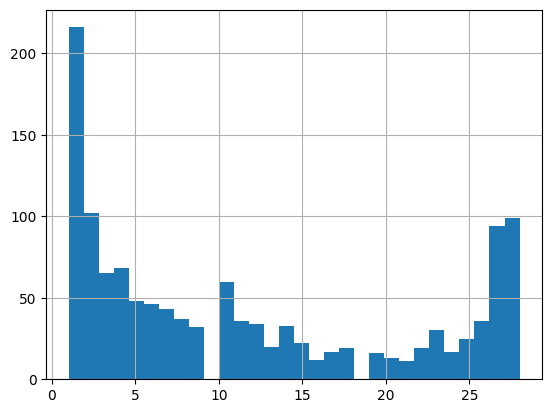

In [11]:
features['count'].hist(bins=30)

Keep features in at least X samples

In [12]:
features = features[features['count'] >= 5]

In [13]:
lrdata_all = sc.concat(lrdatas, join='outer', fill_value=0)
lrdata_all

AnnData object with n_obs × n_vars = 91205 × 1270
    obs: 'in_tissue', 'array_row', 'array_col', 'sample', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'mt_frac', 'celltype_niche', 'molecular_niche', 'n_genes'
    obsm: 'compositions', 'mt', 'spatial'

In [14]:
# subset to de features
lrdata_all = lrdata_all[:, features.index]
lrdata_all

View of AnnData object with n_obs × n_vars = 91205 × 819
    obs: 'in_tissue', 'array_row', 'array_col', 'sample', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'mt_frac', 'celltype_niche', 'molecular_niche', 'n_genes'
    obsm: 'compositions', 'mt', 'spatial'

## Run NMF

In [15]:
li.multi.nmf(lrdata_all, n_components=None, inplace=True, random_state=1337, max_iter=400, verbose=True, k_range=range(1, 21))

  0%|          | 0/20 [00:00<?, ?it/s]

/home/dbdimitrov/.local/lib/python3.10/site-packages/sklearn/decomposition/_nmf.py:1710: ConvergenceWarning: Maximum number of iterations 400 reached. Increase it to improve convergence.
100%|██████████| 20/20 [25:24<00:00, 76.23s/it] 
Estimated rank: 5


In [16]:
lrdata_all.write_h5ad(os.path.join('results', 'lr', 'lrdata_all.h5ad'))

... storing 'sample' as categorical
... storing 'celltype_niche' as categorical
... storing 'molecular_niche' as categorical


In [17]:
lr_loadings = li.ut.get_variable_loadings(lrdata_all, varm_key='NMF_H').set_index('index')

In [18]:
metadata = metadata.reset_index().set_index('hca_sample_id')

In [19]:
# save the NMF factors to the individual samples
for sample in lrdatas:
    labl = metadata.loc[sample, 'major_labl']
    lrdata = lrdatas[sample]
    # Get the NMF factors for the current sample from the full dataset
    temp = lrdata_all[lrdata_all.obs.index.isin(lrdata.obs.index), :]
    temp = temp[:, temp.var.index.isin(lrdata.var.index)]
    
    # extract NMF from obsm
    ad_nmf = sc.AnnData(X=temp.obsm['NMF_W'],
                        obs=temp.obs,
                        var=pd.DataFrame(index=lr_loadings.columns),
                        uns=lrdata.uns,
                        obsm={'spatial':temp.obsm['spatial']}
                        )
    ad_nmf.write_h5ad(os.path.join('results', 'nmf', sample + '.h5ad'))
    
    # plot
    # sq.pl.spatial_scatter(ad_nmf, color=[None, *lr_loadings.columns], cmap='viridis', title=f"{sample}:{labl}", vmin=0, size=1.4, img=True) #
    # plt.show() 

Check loadings

In [9]:
lrdata_all = sc.read_h5ad(os.path.join('results', 'lr', 'lrdata_all.h5ad'))

In [10]:
lr_loadings = li.ut.get_variable_loadings(lrdata_all, varm_key='NMF_H').set_index('index')

In [11]:
metadata = metadata.reset_index().set_index('hca_sample_id')

### Analyse Loadings

In [12]:
nmfdata = sc.AnnData(X=lrdata_all.obsm['NMF_W'].copy(),
                     obs=lrdata_all.obs,
                     var=pd.DataFrame(index=lr_loadings.columns),
                     uns=lrdata_all.uns,
                     obsm={'spatial':lrdata_all.obsm['spatial']}
                     )

In [13]:
indices = lrdata_all.obs.index
nmfdata.obs = nmfdata.obs.merge(metadata.reset_index(), left_on='sample', right_on='slide_name')
nmfdata.obs.index = indices

/home/dbdimitrov/miniconda3/envs/spiana/lib/python3.10/site-packages/anndata/_core/anndata.py:798: UserWarning: 
AnnData expects .obs.index to contain strings, but got values like:
    [0, 1, 2, 3, 4]

    Inferred to be: integer



In [14]:
errors = lrdata_all.uns['nmf_errors']
rank = lrdata_all.uns['nmf_rank']

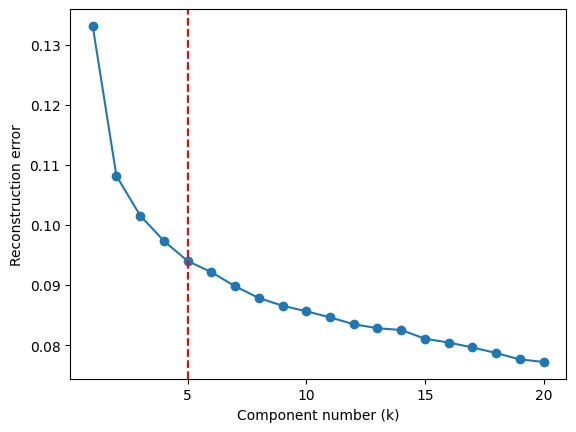

In [15]:
import matplotlib.pyplot as plt

# Create a new figure and axis
fig, ax = plt.subplots()

# Plot the line and points
ax.plot(errors['k'], errors['error'], marker='o')

# Add the vertical line
ax.axvline(x=rank, linestyle='--', color='red')

# Set the x-ticks only if they are divisible by 5
ax.set_xticks([x for x in errors['k'].values if x % 5 == 0])

# Set the labels
ax.set_xlabel('Component number (k)')
ax.set_ylabel('Reconstruction error')

# Show the plot
plt.show()

Averages per slide

In [16]:
nmfdata.write_h5ad(os.path.join('results', 'nmf', 'nmfdata.h5ad'))

... storing 'sample' as categorical
... storing 'hca_sample_id' as categorical
... storing 'slide_name' as categorical
... storing 'patient' as categorical
... storing 'patient_region_id' as categorical
... storing 'patient_group' as categorical
... storing 'major_labl' as categorical
... storing 'batch' as categorical


In [17]:
nmfbulk = dc.get_pseudobulk(nmfdata,
                            sample_col='hca_sample_id',
                            groups_col=None,
                            mode='mean',
                            skip_checks=True,
                            min_cells=0,
                            min_counts=0,
                            min_prop=None,
                            min_smpls=None
                            )

In [18]:
nmfbulk.obs['patient_group'] = nmfbulk.obs['patient_group'].map(rename_dict)

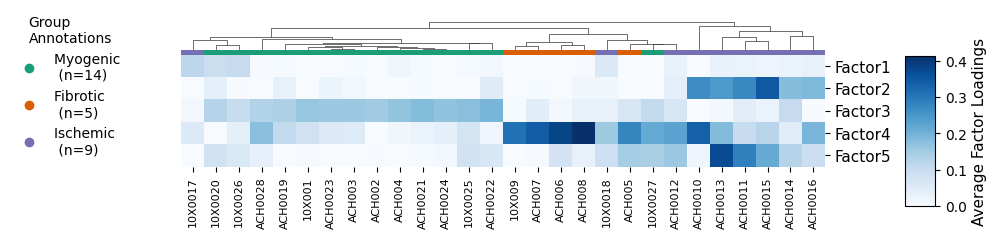

In [19]:

group_annotations = nmfbulk.obs['patient_group'].values
group_labels = set(group_annotations)
# import colour map Dark2 from seaborn
cmap = sns.color_palette('Dark2', n_colors=len(group_labels))
# get cmap values for each group annotation as hex
group_cmap = dict(zip(group_labels, cmap))
group_cols = [group_cmap[key] for key in group_labels]

chart = sns.clustermap(nmfbulk.X.T,
                       cmap='Blues',
                       cbar_kws={'orientation':'vertical'},
                       row_cluster=False,
                       col_cluster=True,
                       col_colors=[group_cmap[x] for x in group_annotations],
                       figsize=(10, 2.5),
                       xticklabels=nmfbulk.obs.index,
                       yticklabels=nmfbulk.var.index,
                       cbar_pos=None
                       )
# # rotate labels
chart.ax_heatmap.set_yticklabels(chart.ax_heatmap.get_ymajorticklabels(), rotation=0, fontdict={'fontsize':11})
chart.ax_heatmap.set_xticklabels(chart.ax_heatmap.get_xmajorticklabels(), fontsize=8)

# create separate axes for colorbar
cbar_ax = chart.fig.add_axes([.9, .2, .03, .6])  # x, y, width, height
cbar = plt.colorbar(chart.ax_heatmap.get_children()[0], cax=cbar_ax)
cbar.set_label('Average Factor Loadings', size=11, loc='center')  # Add title to the colorbar

# Create custom legend
legend_handles = []
for label, color in zip(group_labels, group_cols):
    legend_handles.append(plt.Line2D([0], [0], color=color, marker='o', linestyle='', label=label))

# Add legend
legend = plt.legend(handles=legend_handles, title='Group\nAnnotations', loc='upper right', frameon=False)

# Move the legend
chart_size = chart.ax_heatmap.get_position()
plt.setp(legend.get_title(), fontsize='medium')
legend.set_bbox_to_anchor((chart_size.x1-26.5, chart_size.y0+1))
plt.subplots_adjust(right=.82)
plt.show()

### Pathway Enrichment

In [20]:
lr_nmf = pd.DataFrame(lrdata_all.varm['NMF_H'], index=lrdata_all.var.index, columns=lr_loadings.columns)

In [21]:
lr_nmf.to_csv(os.path.join('results', 'lr_loadings.csv'))

In [22]:
lr_nmf.sort_values("Factor3", ascending=False).head(10)

,Factor1,Factor2,Factor3,Factor4,Factor5
S100A1^RYR2,2.948635,0.000000,4.654873,0.470144,0.843711
CALM1^RYR2,3.278415,0.000000,4.542690,0.590025,0.863719
COL1A2^CD36,3.181974,1.355120,4.042604,1.452428,0.481682
LGALS1^ITGB1,5.132713,1.378386,4.006926,1.483342,0.297796
VWF^ITGB1,4.028054,1.187034,3.989008,1.213392,0.574224
CALM1^AQP1,3.219470,0.705281,3.909754,0.913420,0.782363
CD99^CD81,4.231566,1.285956,3.907100,1.412619,0.501532
C3^CD81,2.656260,1.434660,3.848648,1.069064,0.000000
TIMP1^CD63,5.717086,1.515435,3.750659,1.759758,0.070026
HLA-A^APLP2,4.378465,1.461335,3.736003,1.287446,0.295845


Read NMF results

In [23]:
lr_nmf = pd.read_csv(os.path.join('results', 'lr_loadings.csv'), index_col=0)

In [24]:
# load PROGENy pathways
net = dc.get_progeny(organism='human', top=5000)
# load full list of ligand-receptor pairs
lr_pairs = li.resource.select_resource('consensus')

/home/dbdimitrov/.local/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html


In [25]:
# generate ligand-receptor geneset
lr_progeny = li.rs.generate_lr_geneset(lr_pairs, net, lr_sep="^")
lr_progeny.head()

,source,interaction,weight
1,JAK-STAT,LGALS9^PTPRC,1.307807
74,Androgen,SEMA4D^MET,-0.831693
90,Androgen,HGF^MET,-1.288956
106,Androgen,TIMP3^MET,-1.122612
151,NFkB,SELE^CD44,3.332552


In [26]:
# run pathway enrichment analysis
estimate, pvals =  dc.run_ulm(lr_nmf.transpose(),
                              lr_progeny,
                              source="source",
                              target="interaction",
                              use_raw=False,
                              min_n=5)

In [27]:

# Pivot and merge data
estimate_long = estimate.melt(ignore_index=False, value_name='estimate', var_name='pathway').reset_index().rename(columns={'index':'factor'})
pvals_long = pvals.melt(ignore_index=False, value_name='pval', var_name='pathway').reset_index().rename(columns={'index':'factor'})
dc_res = estimate_long.merge(pvals_long, on=['factor', 'pathway'])

In [28]:
dc_res['adj_pval'] = p_adjust_fdr(dc_res['pval'])

In [91]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import TwoSlopeNorm

def create_heatmap(res, 
                   fill = 'estimate', 
                   index_key="factor",
                   column_key='pathway',
                   label='pval',
                   xlabel = None,
                   cbar_label=None,
                   max_value=None, significance_level=0.05,
                   filter_significant=True,
                   figsize=(4, 3),
                   cmap='RdBu_r',
                   ax=None):
    res = res.copy()
    if max_value is not None:
        res.loc[res[fill] > max_value, fill] = max_value
        res.loc[res[fill] < -max_value, fill] = -max_value
    
    res['significant'] = res[label].apply(lambda x: '*' if x < significance_level else '')
    
    if filter_significant:
        sig_paths = res[res[label] <= significance_level][column_key].unique()
    else:
        sig_paths = res[column_key].unique()

    # Filter for significant pathways
    filtered_data = res[res[column_key].isin(sig_paths)]
    # Create pivot table for heatmap
    heatmap_data = filtered_data.pivot(index=index_key, columns=column_key, values=fill)
    heatmap_data.sort_index(inplace=True, ascending=False)
    
    if max_value is None:
        norm = TwoSlopeNorm(vmin=-max_value, vcenter=0, vmax=max_value)
    else:
        norm = None
    
    # Plotting
    if ax is None:
        plt.figure(figsize=figsize)
        ax = plt.gca()

    heatmap = ax.pcolormesh(heatmap_data, cmap=cmap, norm=norm)

    # Adding Text Annotations
    for y, row in enumerate(heatmap_data.index):
        for x, column in enumerate(heatmap_data.columns):
            value = filtered_data.loc[(filtered_data[index_key] == row) &
                                       (filtered_data[column_key] == column), 'significant'].values[0]
            
            ax.text(x + 0.5, y + 0.4,
                     value,
                     horizontalalignment='center', 
                     verticalalignment='center',
                     color='white',
                     fontstyle='oblique',
                     fontsize=30
                     )

    # Styling
    cbar = plt.colorbar(heatmap, ax=ax)
    ax.set_xticks(np.arange(0.5, len(heatmap_data.columns), 1))
    ax.set_xticklabels(heatmap_data.columns, rotation=90, fontsize=14)
    ax.set_yticks(np.arange(0.5, len(heatmap_data.index), 1))
    ax.set_yticklabels(heatmap_data.index, fontsize=14)
    cbar.ax.tick_params(labelsize=14)
    
    if xlabel is not None:
        ax.set_xlabel(xlabel, fontsize=15)
    if cbar_label is not None:
        cbar.set_label(cbar_label, size=15)
    
    ax.set_ylabel('')
    plt.tight_layout()
    plt.show()

Odds Ratios on the Average Sample Loadings

In [30]:
df = pd.DataFrame(nmfbulk.X, columns=lr_loadings.columns, index=nmfbulk.obs.index)
df['sample'] = nmfbulk.obs['sample']
df = df.merge(metadata.reset_index(), left_on='sample', right_on='slide_name')

In [31]:
import pandas as pd
from scipy.stats import fisher_exact

# Assuming df is your pandas DataFrame
factors = lr_loadings.columns
labels = df['patient_group'].unique()

# Initialize a DataFrame to store the results
odds = pd.DataFrame(columns=['factor', 'patient_group', 'odds_ratio', 'p_value'])

# Iterate over each factor and each label
for factor in factors:
    # Determine the top threshold
    threshold = df[factor].quantile(0.75)
    
    for label in labels:
        # Create a 2x2 contingency table
        top_and_label = sum((df[factor] >= threshold) & (df['patient_group'] == label))
        top_and_not_label = sum((df[factor] >= threshold) & (df['patient_group'] != label))
        not_top_and_label = sum((df[factor] < threshold) & (df['patient_group'] == label))
        not_top_not_label = sum((df[factor] < threshold) & (df['patient_group'] != label))
        
        contingency_table = [[top_and_label, top_and_not_label],
                             [not_top_and_label, not_top_not_label]]
        
        # Perform Fisher's exact test
        odds_ratio, p_value = fisher_exact(contingency_table)
        
        # Store results
        odds.loc[len(odds)] = [factor, label, odds_ratio, p_value]


In [32]:
odds['log2_odds'] = np.log2(odds['odds_ratio'])

# if -inf, set to min (except -inf)
odds['log2_odds'] = odds.apply(lambda x: np.log2(1/1000) if x['log2_odds'] == -np.inf else x['log2_odds'], axis=1)
# if inf, set to max
odds['log2_odds'] = odds.apply(lambda x: np.log2(1000) if x['log2_odds'] == np.inf else x['log2_odds'], axis=1)

/home/dbdimitrov/miniconda3/envs/spiana/lib/python3.10/site-packages/pandas/core/arraylike.py:402: RuntimeWarning: divide by zero encountered in log2


In [33]:
odds['adj_pval'] = p_adjust_fdr(odds['p_value'])

In [34]:
# as category and alphabetical
odds['patient_group'] = odds['patient_group'].astype('category')
odds['patient_group'] = odds['patient_group'].cat.reorder_categories(sorted(odds['patient_group'].unique()))

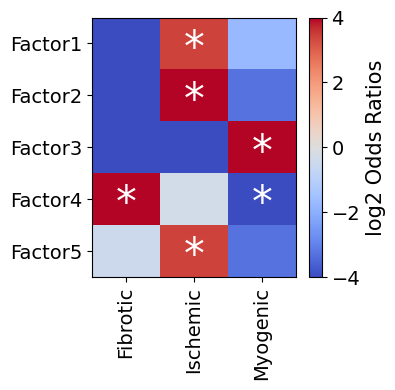

In [92]:
create_heatmap(odds, label='adj_pval', fill='log2_odds', index_key="factor", column_key='patient_group',
               cbar_label="log2 Odds Ratios", significance_level=0.05, 
               max_value=4, figsize=(4, 4), cmap='coolwarm')

In [36]:
from adjustText import adjust_text
def plot_lr_pairs(H,
                  fct,
                  label_fun, 
                  figsize=(6, 6),
                  method='average',
                  filename=None, 
                  adjust_text_kwargs={'arrowprops': dict(arrowstyle='->', color='darkred')}):
    lr_pairs = H[fct].reset_index()
    lr_pairs['rank'] = lr_pairs[fct].rank(ascending=False, method=method)
    lr_pairs['name'] = lr_pairs.apply(label_fun, axis=1)

    fig, ax = plt.subplots(figsize=figsize)
    ax.scatter(lr_pairs['rank'], lr_pairs[fct], s=30, c='black')

    y_max = lr_pairs[fct].max()
    ax.set_ylim(lr_pairs[fct].min(), y_max + y_max * 0.1)
    x_max = lr_pairs['rank'].max()
    ax.set_xlim(lr_pairs['rank'].min()-1, x_max + x_max * 0.05)

    ax.set_xlabel('Rank', fontsize=14)
    ax.set_ylabel(f'{fct} loadings', fontsize=16)
    plt.xticks(fontsize=14)
    plt.yticks(fontsize=14)
    
    texts = []
    for i, row in lr_pairs.iterrows():
        if row['name']:
            texts.append(ax.text(row['rank'], row[fct], row['name'], fontsize=11, color='darkred')) 

    adjust_text(texts, **adjust_text_kwargs)
    
    plt.tight_layout()
    if filename:
        plt.savefig(filename, bbox_inches='tight')
    else:
        plt.show()

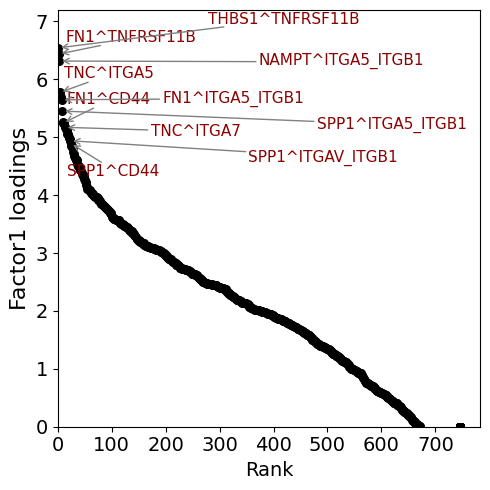

In [37]:
plot_lr_pairs(lr_loadings, 
              fct='Factor1',
              # lambada to check if index contains any of the substrings ("FN1|NAMPT") else None
              label_fun=lambda x: x['index'] if (any([s in x['index'] for s in ["FN1", 'NAMPT', 'TNC', 'THBS1', 'SPP1']]) and (x['rank'] <= 25)) else None,
              figsize=(5, 5),
              adjust_text_kwargs={'arrowprops': dict(arrowstyle='->', color='grey', lw=1), 
                                  'expand_text':(1, 1.5),
                                  'expand_points':(1.1, 1.5),
                                  # 'force_explode':(0.4, 0.4),
                                  # 'force_text':(0.5, 0.5),
                                #   'expand': (2, 1),
                                  }
              )

In [38]:
lr_loadings.sort_values("Factor1", ascending=False).head(5)

,Factor1,Factor2,Factor3,Factor4,Factor5
index,,,,,
THBS1^TNFRSF11B,6.542176,0.000000,0.021250,0.000000,0.002154
FN1^TNFRSF11B,6.435771,0.000000,0.124430,0.000000,0.004698
NAMPT^ITGA5_ITGB1,6.314688,1.082256,1.181560,0.573935,0.149948
TNC^ITGA5,5.773120,0.777653,0.030749,0.297626,0.502283
TIMP1^CD63,5.717086,1.515435,3.750659,1.759758,0.070026


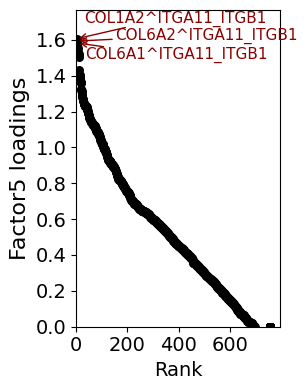

In [39]:
plot_lr_pairs(lr_loadings, 
              fct='Factor5',
              label_fun=lambda x: x['index'] if x['rank'] <= 3 else None,
              figsize=(3, 4),
              adjust_text_kwargs={'arrowprops': dict(arrowstyle='->', color='darkred', lw=1), 
                                  'expand_text':(1, 1),
                                  'expand_points':(1.1, 1.5),
                                  # 'force_explode':(0.4, 0.4),
                                  # 'force_text':(0.5, 0.5),
                                #   'expand': (2, 1),
                                  }
              )

In [40]:
from scipy.stats import spearmanr

In [41]:
# pairwise correlations between factors
for i in range(0, nmfdata.shape[1]):
    for j in range(i+1, nmfdata.shape[1]):
        print(f"Factor{i+1} vs Factor{j+1}: {spearmanr(nmfdata.X[:, i], nmfdata.X[:,j])}")

Factor1 vs Factor2: SignificanceResult(statistic=0.35393803201556323, pvalue=0.0)
Factor1 vs Factor3: SignificanceResult(statistic=-0.16444593815436553, pvalue=0.0)
Factor1 vs Factor4: SignificanceResult(statistic=-0.29672125864733023, pvalue=0.0)
Factor1 vs Factor5: SignificanceResult(statistic=0.3776665463445611, pvalue=0.0)
Factor2 vs Factor3: SignificanceResult(statistic=-0.2640645594902651, pvalue=0.0)
Factor2 vs Factor4: SignificanceResult(statistic=-0.0021434041412068793, pvalue=0.5174355554898742)
Factor2 vs Factor5: SignificanceResult(statistic=0.42373417367585287, pvalue=0.0)
Factor3 vs Factor4: SignificanceResult(statistic=-0.6318093637550714, pvalue=0.0)
Factor3 vs Factor5: SignificanceResult(statistic=-0.18017207443084737, pvalue=0.0)
Factor4 vs Factor5: SignificanceResult(statistic=0.14303056286558904, pvalue=0.0)


Select Spatially-interesting LRs

In [42]:
lr_nmf = pd.read_csv(os.path.join('results', 'lr_loadings.csv'), index_col=0)
# pivot longer
lr_nmf = lr_nmf.reset_index().melt(id_vars='index', var_name='factor', value_name='loading')

In [43]:
lr_nmf['top5'] = lr_nmf.groupby('factor').apply(lambda x: x['loading'] >= x['loading'].quantile(0.95)).values
lr_nmf['top1std'] = lr_nmf.groupby('factor').apply(lambda x: x['loading'] >= x['loading'].quantile(0.68)).values

In [44]:
lr_nmf.reset_index(drop=True, inplace=True)

# separete by ^ into ligand and receptor
lr_nmf['ligand'] = lr_nmf['index'].str.split('^').str[0]
lr_nmf['receptor'] = lr_nmf['index'].str.split('^').str[1]
resource = lr_nmf.drop_duplicates(['ligand', 'receptor'])

In [45]:
resource.to_csv(os.path.join("results", 'lr_pairs.csv'), index=False)

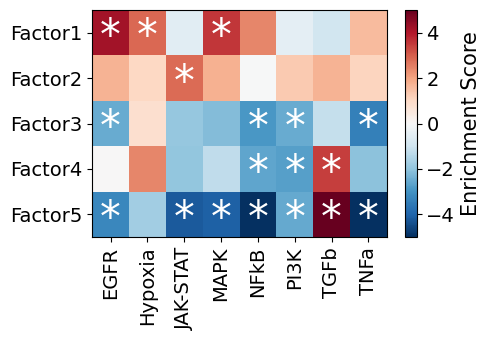

In [110]:

# Plot the first scatter plot in the first subplot; NOTE this plot does not work with squpdpy..
create_heatmap(dc_res,
               index_key="factor",
               column_key='pathway',
               label='adj_pval', 
               xlabel="",
               figsize=(5, 3.5),
               cbar_label='Enrichment Score',
               significance_level=0.05,
               max_value=5)

Visualise LRs

In [107]:
sample_id = 'ACH0014'
interaction = 'FN1^ITGA5_ITGB1' # 'SPP1^ITGA5_ITGB1'
labels = {'Factor1':'NMF Loadings', 'FN1^ITGA5_ITGB1':'Cosine Similarity', 'SPP1^ITGA5_ITGB1':'Cosine Similarity'}
plot_kwargs = {'img':False, 'frameon':False,'size':1.55, 'figsize':(5, 5), 'return_ax':False}


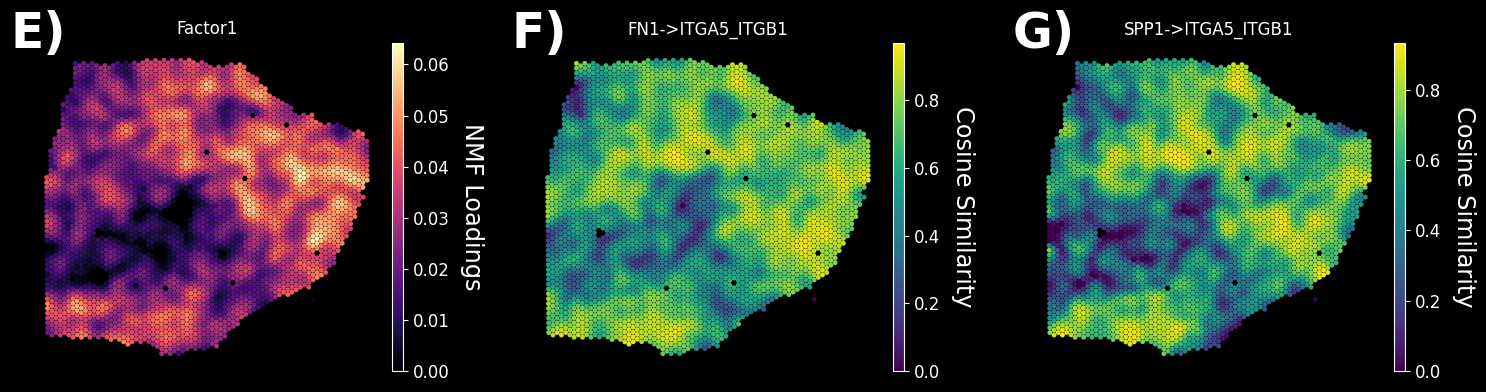

In [112]:
# set background to black
plt.style.use('dark_background')

fig, axs = plt.subplots(1, 3, figsize=(17, 4))

lrdata = sc.read_h5ad(os.path.join('results', 'lr', sample_id + '.h5ad'))
nmfdata = sc.read_h5ad(os.path.join('results', 'nmf', sample_id + '.h5ad'))

# Plot the second scatter plot in the second subplot

for i, (label, title) in enumerate(labels.items()):
    
    if label == 'Factor1':
        # Plot the first scatter plot in the first subplot
        sq.pl.spatial_scatter(nmfdata, color=[label], ax=axs[i], **plot_kwargs, title=label, cmap='magma')
    else:
        sq.pl.spatial_scatter(lrdata, color=[label], ax=axs[i], **plot_kwargs, title=label.replace('^', '->'))

    cbar = axs[i].collections[0].colorbar
    cbar.set_label(labels[label], rotation=270, labelpad=25, fontsize='xx-large')
    cbar.ax.tick_params(labelsize='large') # , colors='white'

# Add D), E), F), G)
sublabs = ['E)', 'F)', 'G)']
for i, ax in enumerate(axs):
    ax.text(-0.05, 1.1, sublabs[i], transform=ax.transAxes, fontsize=35, fontweight='bold', va='top')

# force the subplot to be close
plt.subplots_adjust(wspace=-0.4)
plt.tight_layout()

# Show the plot
plt.show()